# Working with ODEs in Julia
To simulate (systems of) ODEs in Julia, we use the [DifferentialEquations](https://docs.sciml.ai/DiffEqDocs/stable/) module. This makes it easy to define all kinds of ODE systems, from very simple towards increasingly complicated definitions. This overview shows some of the basic functionality of ODE systems, from simulating a basic set of equations to the use of callbacks to perturb the system at given timepoints. We start with importing some of the required modules into Julia with the `using` keyword. In this example, we only use the `DifferentialEquations` module and the `Plots` module for plotting our final solutions.

In [1]:
using DifferentialEquations, Plots

## Defining a system of differential equations

To illustrate this, we introduce the well-known SIR model. A simplistic three compartment model used to model epidemics. Each compartment defines a part of the population that is Susceptible, Infected, or Recovered, hence the acronym SIR. The basic model, normalized to proportions of the population ($S+I+R = 1$) is defined as:
$$
\begin{align}
\frac{\mathrm{d}S}{\mathrm{d}t} &= -\beta IS \\
\frac{\mathrm{d}I}{\mathrm{d}t} &= \beta IS - \gamma I \\
\frac{\mathrm{d}R}{\mathrm{d}t} &= \gamma I \\
\end{align}
$$

In the differential equations library in Julia, there are a couple of ways of defining the system of differential equations. We will initially discuss two ways, each with their advantages and disadvantages. At the end, a third way will be discussed, using the ModelingToolkit library.

The `DifferentialEquations` package defines an `ODEProblem` object that takes in a function specifying the ODE system, and optionally a vector of initial conditions, the time span for which to solve the system, and a vector of parameters used. To actually solve the system, these last three are required, but can be specified to the `solve` function as well. However, it is good practice to always provide the necessary arguments to the `ODEProblem` definition when possible. In any case, arguments passed to the `solve` function will be used over the default arguments specified in the `ODEProblem`. 

Now, let's define the SIR model in Julia. We start by specifying the ODE system. We can do this by defining a function that takes in the state vector `u`, the current time `t` and the parameters `p`, and returns the derivative vector `du`.

In [2]:
function SIRModel(u, p, t)
  
  # unpack p
  β, γ = p

  # unpack u
  S, I, R = u

  # define equations
  dSdt = -β*I*S
  dIdt = β*I*S - γ*I
  dRdt = γ*I

  [dSdt, dIdt, dRdt]
end

SIRModel (generic function with 1 method)

Another way of defining this function is by giving it `du` as an input argument as well, and making it *modify* the derivative vector. This is more efficient, because in the function above, Julia allocates memory for every new `du` that is returned from the function, while in the next case, only one piece of memory is allocated for `du`. Notice that this function has an exclamation point (!) at the end, which is a Julia convention for functions that modify their first input argument.

In [3]:
function SIRModel!(du, u, p, t)
  
  # unpack p
  β, γ = p

  # unpack u
  S, I, R = u

  # define equations
  dSdt = -β*I*S
  dIdt = β*I*S - γ*I
  dRdt = γ*I

  du[1:3] = [dSdt, dIdt, dRdt]

  nothing # return nothing
end

SIRModel! (generic function with 1 method)

To be able to simulate, we need to construct an `ODEProblem` object. We will define our parameters as $\beta = 0.12$ and $\gamma = 0.02$, and define `u0` as:
$$
\begin{pmatrix}
S &=& 0.9999 \\
I &=& 0.0001 \\
R &=& 0. \\
\end{pmatrix}
$$

Lastly, we wish to simulate for 250 days. We can define our ODEProblem in both ODE specifications in the same way:

In [4]:
u0 = [0.9999, 0.0001, 0.]
tspan = (0, 250)
p = [0.12, 0.02]

sirproblem1 = ODEProblem(SIRModel, u0, tspan, p)
sirproblem2 = ODEProblem(SIRModel!, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 250)
u0: 3-element Vector{Float64}:
 0.9999
 0.0001
 0.0

We see that we have successfully managed to define an ODE problem. We will now move on to simulating the systems.

## Simulation
To simulate these ODE problems, we need the `solve` function. In the simplest way, we can just call solve on our ODE problem, and it will return a solution. However, we can also specify solvers, or algorithm hints, which we will discuss later.

In [5]:
solution1 = solve(sirproblem1)
solution2 = solve(sirproblem2);

Now we can also plot this solution easily, as this library defines its custom plot recipe for an ODE solution object. We see that both our solutions are equal (up to some numerical precision differences).

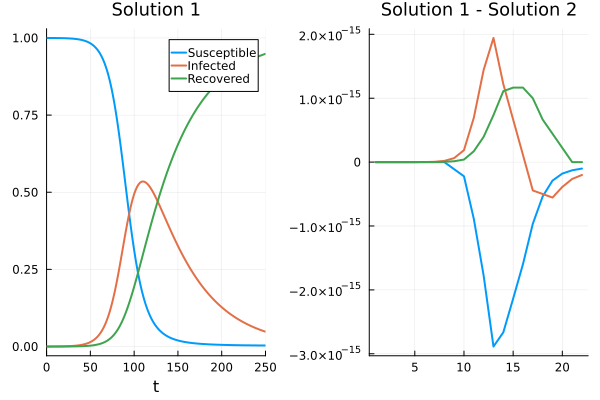

In [6]:
plot(
  plot(solution1, title = "Solution 1", labels = ["Susceptible" "Infected" "Recovered"]),
  plot(solution1'-solution2', title="Solution 1 - Solution 2", legend=false), 
  titlefontsize=12, linewidth=2
  )

Now, what is then the difference between the two ways of specifying the ODEs? Observe the following benchmarks:

In [21]:
using BenchmarkTools
@benchmark solve(sirproblem1)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  55.416 μs …   3.153 ms  ┊ GC (min … max):  0.00% … 96.93%
 Time  (median):     56.958 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   67.606 μs ± 163.387 μs  ┊ GC (mean ± σ):  13.08% ±  5.30%

  ▄▇█▇▆▅▅▅▄▄▂▁  ▁▁▁▁▁▂▁▁▂▁ ▁▁▁ ▁                               ▂
  ████████████████████████████████▇█▇▇▆▇▅▅▅▅▄▄▅▅▄▄▅▄▅▅▅▄▄▃▁▁▅▅ █
  55.4 μs       Histogram: log(frequency) by time      83.6 μs <

 Memory estimate: 138.00 KiB, allocs estimate: 1741.

In [22]:
@benchmark solve(sirproblem2)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  17.584 μs …  3.409 ms  ┊ GC (min … max): 0.00% … 98.37%
 Time  (median):     18.250 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.706 μs ± 81.942 μs  ┊ GC (mean ± σ):  9.58% ±  2.41%

  ▁▅▇██▇▆▅▃▂▂▁▁▂▁▂▂▂▂▁▂                                       ▂
  █████████████████████████▇██▇▇▆▇▆▅▄▅▄▅▄▄▄▄▄▃▄▂▃▅▄▅▄▃▂▂▄▃▃▂▃ █
  17.6 μs      Histogram: log(frequency) by time      26.5 μs <

 Memory estimate: 35.98 KiB, allocs estimate: 433.

Even though the absolute differences in time are not very large, we observe a 3 times speedup in the second case, looking at the median time taken. Moreover, the memory estimate is far lower in the second case.

## Solvers
Besides just calling `solve(::ODEProblem)` we can also specify one of the vast array of solvers provided by the `DifferentialEquations` package. Additionally, the seamless C-integration of Julia has also been exploited to give users fully functioning ODE solvers from the Sundials library, in case `Sundials.jl` is installed as a package. By default, the `solve` function selects an algorithm for you, which works well in most cases. However, sometimes automatic stiffness detection fails. If you know beforehand that you need a stiff solver, you can also provide this as an `alg_hint`. Consider the following stiff equation (taken from Matlab's `ode23s` documentation). In the next plot, we show the functionality of alg_hints, when stiffness detection identifies the stiff equation properly.

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/max/.julia/packages/SciMLBase/kTUaf/src/integrator_interface.jl:580


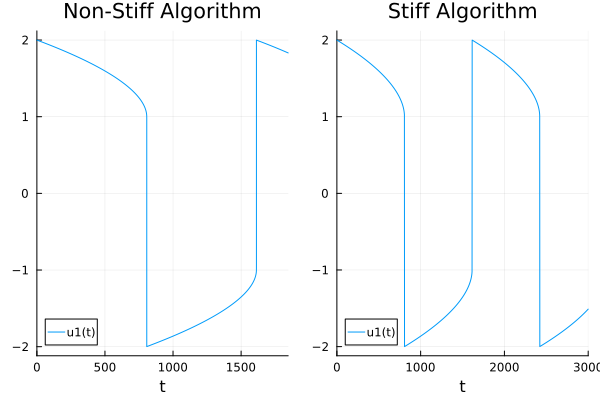

In [20]:
function stiffode!(du, u, p, t)
  du[1:2] = [
    u[2], p[1]*(1-u[1]^2)*u[2]-u[1]
  ]
  nothing
end

stiffproblem = ODEProblem(stiffode!, [2., 0.], (0., 3000.), [1000.])
plot(plot(solve(stiffproblem, alg_hints=[:nonstiff]), idxs=1, title="Non-Stiff Algorithm"), plot(solve(stiffproblem, alg_hints=[:stiff]), idxs=1, title="Stiff Algorithm"))

We see that the nonstiff algorithm quits early with a warning, while the stiff algorithm solves the problem without complaints.

## Callbacks

Callbacks can be used to modify the integration process while it is going. There are various types of callbacks that can be used. The simplest one is the `DiscreteCallback`, which contains a `condition` and an `affect!`, which are both functions. The callback works by performing the `affect!` function as soon as the `condition` returns `true`. Say we have a virus mutation, and suddenly everyone becomes susceptible again after 150 days. We can design this callback as follows:

In [31]:
condition(u, t, integrator) = t == 150
affect!(integrator) = integrator.u[1] = 1.
cb = DiscreteCallback(condition, affect!)

DiscreteCallback{typeof(condition), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

We then add this callback to our solve function.

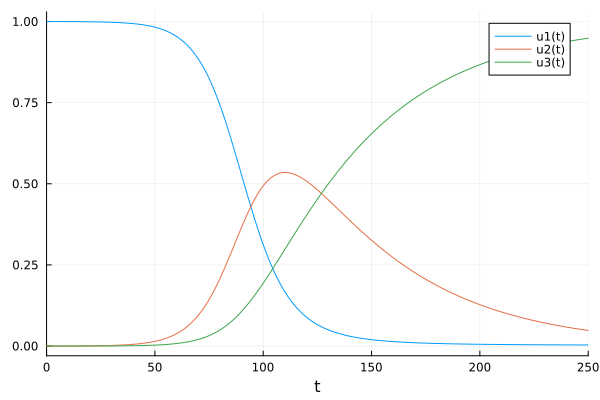

In [32]:
plot(solve(sirproblem2, callback=cb))

Oops... we see that it has no effect at all! This is because the integrator does not arrive at exactly t=150, meaning the condition is *never* evaluated as `true`. To solve this, we can force the integrator to stop at t = 150 using the `tstops` argument.

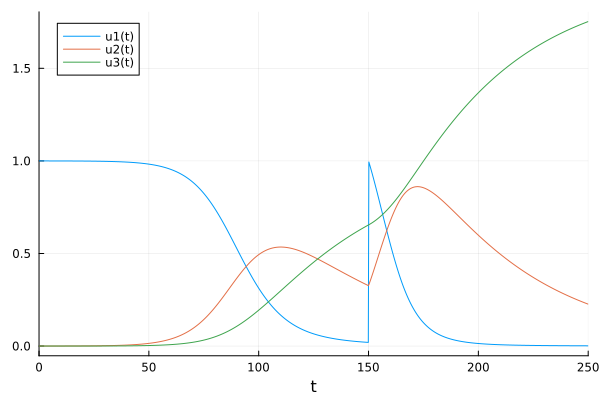

In [30]:
plot(solve(sirproblem2, callback=cb, tstops=150.))

And we see that it works as intended now.

## Acausal Modelling with ModelingToolkit
A third option for defining differential equations is using ModelingToolkit. This is a high-level library that also includes symbolic computation abilities to speed up simulations of complicated systems even further. For this tutorial, we will reuse our previously used SIR model.

In [173]:
using ModelingToolkit

@variables t S(t) I(t) R(t)
@parameters β δ
D = Differential(t)

equations = [
  D(S) ~ -β*S*I,
  D(I) ~ β*S*I - δ*I,
  D(R) ~ δ*I
]

@named sirmodel = ODESystem(equations)

Model sirmodel with 3 equations
States (3):
  S(t)
  I(t)
  R(t)
Parameters (2):
  β
  δ

Similarly, we can define an ODEProblem from a model simulated using ModelingToolkit.

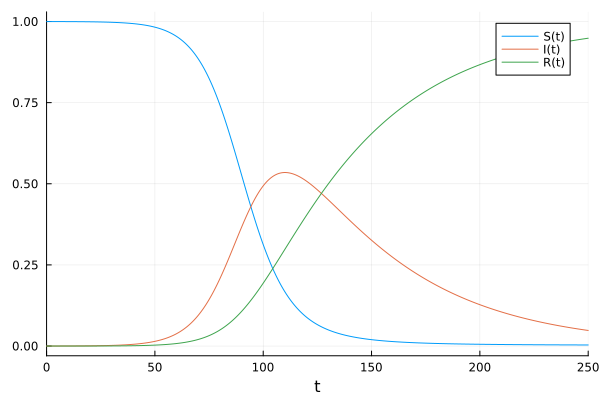

In [174]:
u0 = [
  S => 0.9999, I => 0.0001, R => 0.
  ]
tspan = (0, 250)
p = [β => 0.12, δ => 0.02]

problem = ODEProblem(sirmodel, u0, tspan, p)
plot(solve(problem))

However, this does not seem to be a great advantage over the regular differential equation definitions. The true advantage of ModelingToolkit is in its composability, which is extremely useful when building larger models from smaller components. More about this can be found in the [ModelingToolkit documentation](https://docs.sciml.ai/ModelingToolkit/stable/). 

## Loading SBML Models into ModelingToolkit
Another advantage of ModelingToolkit is that it supports the loading of chemical reaction systems. For example, we can load the Zombie Virus version of the SIR model by downloading it from BioModels.

In [176]:
using Downloads, SBMLToolkit, ModelingToolkit

URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000882.7?filename=munz2000.xml"
output = Downloads.download(URL)

# check support
SBMLToolkit.checksupport_file(output)

mdl = readSBML(output, doc -> begin
  set_level_and_version(3, 2)(doc)
  convert_promotelocals_expandfuns(doc)
end)

odesys = ODESystem(mdl)

Model ##SBML#2024 with 3 equations
States (3):
  Removal(t) [defaults to 0.0]
  Zombie(t) [defaults to 1.0]
  Susceptible(t) [defaults to 500.0]
Parameters (6):
  p [defaults to 0.05]
  alpha [defaults to 0.005]
  zeta [defaults to 0.0001]
  delta [defaults to 0.0001]
⋮

Similar to the previous simulation, we can convert this to an ODEProblem and compute the solution.

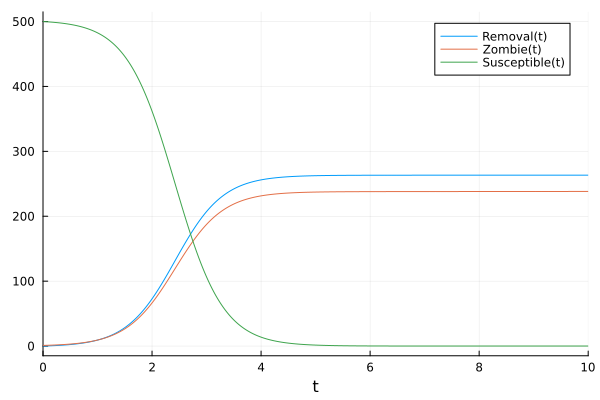

In [190]:
problem = ODEProblem(odesys, [], (0., 10.), [])
plot(solve(problem))